## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 12 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp007'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 12 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([12, 224, 224])

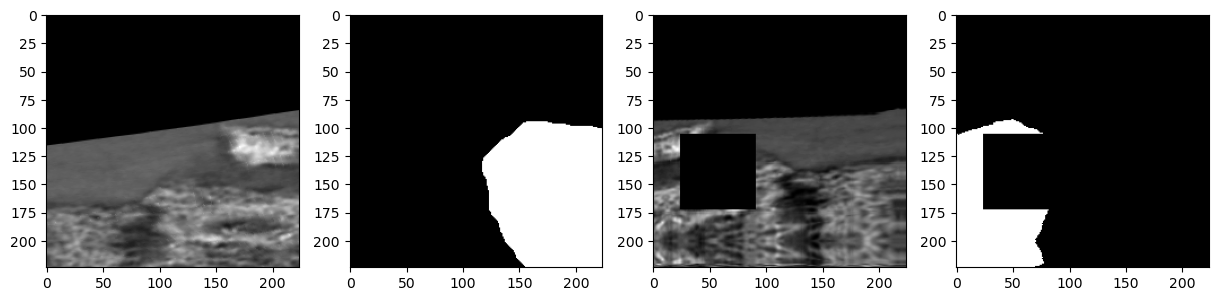

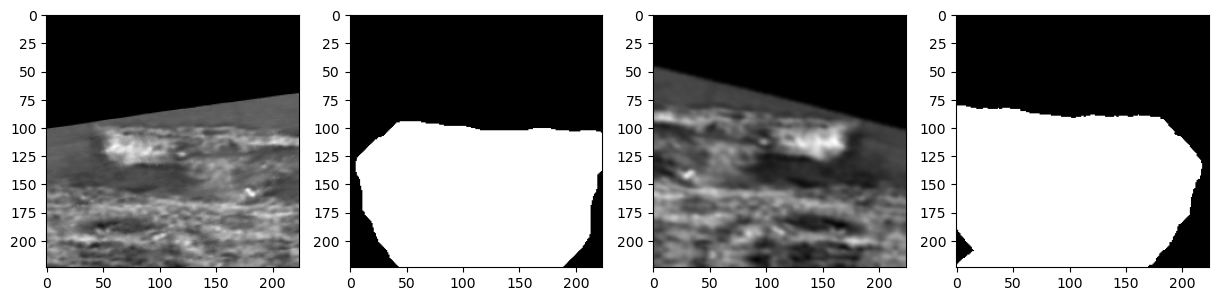

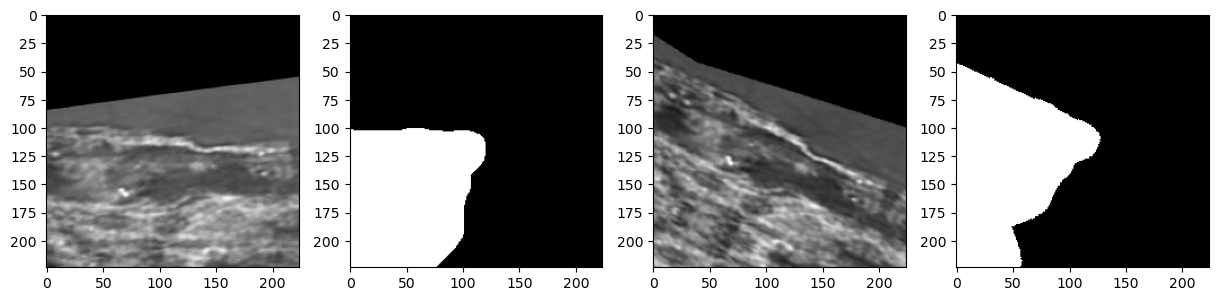

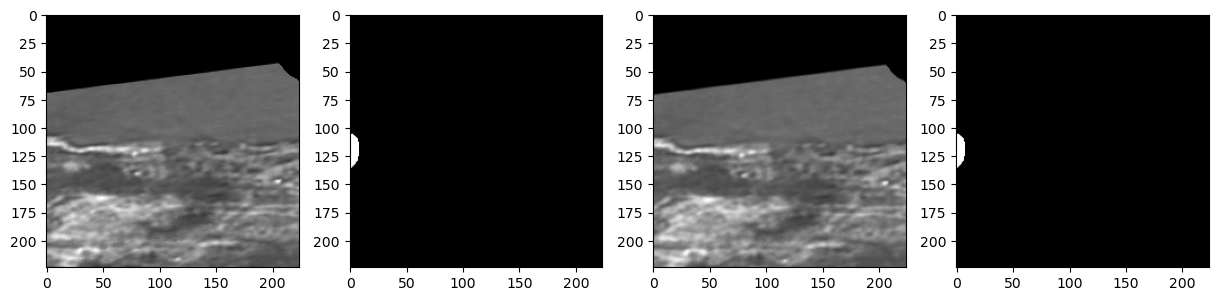

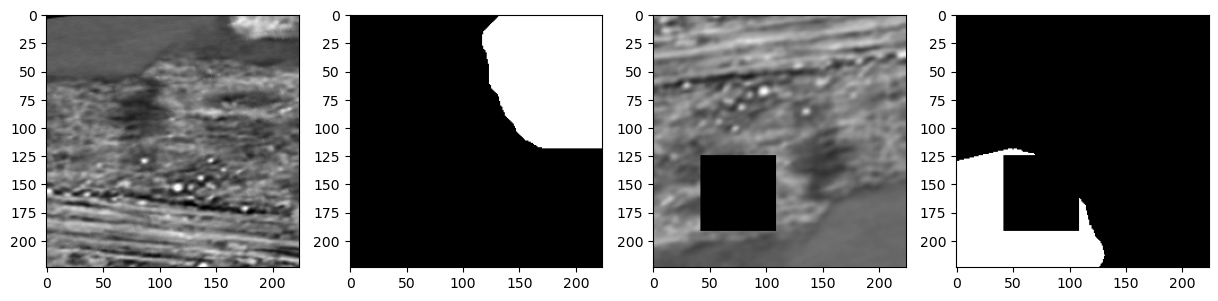

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14326909292811604
th: 0.15, fbeta: 0.18688114553061688
th: 0.2, fbeta: 0.2216732233525738
th: 0.25, fbeta: 0.23362981267576383
th: 0.3, fbeta: 0.2463013418684165
th: 0.35, fbeta: 0.26078944080813
th: 0.4, fbeta: 0.2737880153899518
th: 0.45, fbeta: 0.2713226783158151


best_th: 0.4, fbeta: 0.2737880153899518
Epoch 1 - avg_train_loss: 0.4209  avg_val_loss: 0.4040  time: 164s
Epoch 1 - avgScore: 0.2738
Epoch 1 - Save Best Score: 0.2738 Model
Epoch 1 - Save Best Loss: 0.4040 Model


th: 0.5, fbeta: 0.2259501986701537


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.15561450522799233
th: 0.15, fbeta: 0.23192837606949568
th: 0.2, fbeta: 0.26460494787752
th: 0.25, fbeta: 0.2959455730435404
th: 0.3, fbeta: 0.31972119473650407
th: 0.35, fbeta: 0.3200816662891918
th: 0.4, fbeta: 0.2793804188691831
th: 0.45, fbeta: 0.1975150784556816


best_th: 0.35, fbeta: 0.3200816662891918
Epoch 2 - avg_train_loss: 0.3254  avg_val_loss: 0.3487  time: 164s
Epoch 2 - avgScore: 0.3201
Epoch 2 - Save Best Score: 0.3201 Model
Epoch 2 - Save Best Loss: 0.3487 Model


th: 0.5, fbeta: 0.10433169387296846


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2992190197478368
th: 0.15, fbeta: 0.16914702637360754
th: 0.2, fbeta: 0.0786734663884366
th: 0.25, fbeta: 0.03957640177419394
th: 0.3, fbeta: 0.02080389166722993
th: 0.35, fbeta: 0.009847568017755317
th: 0.4, fbeta: 0.004801682850403162
th: 0.45, fbeta: 0.0025496210175260416


best_th: 0.1, fbeta: 0.2992190197478368
Epoch 3 - avg_train_loss: 0.2429  avg_val_loss: 0.3649  time: 166s
Epoch 3 - avgScore: 0.2992


th: 0.5, fbeta: 0.001356389140520099


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38650053193789086
th: 0.15, fbeta: 0.4257265178602091
th: 0.2, fbeta: 0.4195513490793256
th: 0.25, fbeta: 0.38768404281095226
th: 0.3, fbeta: 0.3388591591467314
th: 0.35, fbeta: 0.29048947642547246
th: 0.4, fbeta: 0.24022320655450916
th: 0.45, fbeta: 0.19111347038717122


best_th: 0.15, fbeta: 0.4257265178602091
Epoch 4 - avg_train_loss: 0.2056  avg_val_loss: 0.3397  time: 165s
Epoch 4 - avgScore: 0.4257
Epoch 4 - Save Best Score: 0.4257 Model
Epoch 4 - Save Best Loss: 0.3397 Model


th: 0.5, fbeta: 0.1462890555009049


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3580615361249491
th: 0.15, fbeta: 0.3349386990226434
th: 0.2, fbeta: 0.30477862423442836
th: 0.25, fbeta: 0.26860773751353134
th: 0.3, fbeta: 0.23222697214595528
th: 0.35, fbeta: 0.1961096999117816
th: 0.4, fbeta: 0.16291074821344115
th: 0.45, fbeta: 0.13067199798935103


best_th: 0.1, fbeta: 0.3580615361249491
Epoch 5 - avg_train_loss: 0.1881  avg_val_loss: 0.4477  time: 167s
Epoch 5 - avgScore: 0.3581


th: 0.5, fbeta: 0.10349624516004949


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3608266999462023
th: 0.15, fbeta: 0.3827900607124041
th: 0.2, fbeta: 0.38571271134870466
th: 0.25, fbeta: 0.37714686987403995
th: 0.3, fbeta: 0.36068285863422045
th: 0.35, fbeta: 0.3393691189477328
th: 0.4, fbeta: 0.3117079181447941
th: 0.45, fbeta: 0.28124620070495315


best_th: 0.2, fbeta: 0.38571271134870466
Epoch 6 - avg_train_loss: 0.1769  avg_val_loss: 0.3989  time: 167s
Epoch 6 - avgScore: 0.3857


th: 0.5, fbeta: 0.25124111889877143


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3703605026351087
th: 0.15, fbeta: 0.36428269102404565
th: 0.2, fbeta: 0.33962990135818993
th: 0.25, fbeta: 0.3080058827383418
th: 0.3, fbeta: 0.2757238935135714
th: 0.35, fbeta: 0.2471086254445793
th: 0.4, fbeta: 0.21647978916651983
th: 0.45, fbeta: 0.1815428706213172


best_th: 0.1, fbeta: 0.3703605026351087
Epoch 7 - avg_train_loss: 0.1640  avg_val_loss: 0.4407  time: 165s
Epoch 7 - avgScore: 0.3704


th: 0.5, fbeta: 0.14464875828604384


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3711110797441009
th: 0.15, fbeta: 0.37455656823172484
th: 0.2, fbeta: 0.3641798775505424
th: 0.25, fbeta: 0.3461676617749769
th: 0.3, fbeta: 0.32193966584651074
th: 0.35, fbeta: 0.2900849981738442
th: 0.4, fbeta: 0.25160244750607486
th: 0.45, fbeta: 0.21709667660876722


best_th: 0.15, fbeta: 0.37455656823172484
Epoch 8 - avg_train_loss: 0.1535  avg_val_loss: 0.4540  time: 166s
Epoch 8 - avgScore: 0.3746


th: 0.5, fbeta: 0.18422745705644758


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3857292678815269
th: 0.15, fbeta: 0.38698781142222866
th: 0.2, fbeta: 0.3779029391900887
th: 0.25, fbeta: 0.36287948668904946
th: 0.3, fbeta: 0.3433905973810508
th: 0.35, fbeta: 0.319733837237174
th: 0.4, fbeta: 0.2947427133054812
th: 0.45, fbeta: 0.2664181199690438


best_th: 0.15, fbeta: 0.38698781142222866
Epoch 9 - avg_train_loss: 0.1458  avg_val_loss: 0.4432  time: 164s
Epoch 9 - avgScore: 0.3870


th: 0.5, fbeta: 0.23657113444687838


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36807207123890573
th: 0.15, fbeta: 0.3663842217430188
th: 0.2, fbeta: 0.359646248190546
th: 0.25, fbeta: 0.35141396754633974
th: 0.3, fbeta: 0.33818754864221273
th: 0.35, fbeta: 0.3211891666617913
th: 0.4, fbeta: 0.3015963859548884
th: 0.45, fbeta: 0.27747105697133817


best_th: 0.1, fbeta: 0.36807207123890573
Epoch 10 - avg_train_loss: 0.1372  avg_val_loss: 0.5155  time: 165s
Epoch 10 - avgScore: 0.3681


th: 0.5, fbeta: 0.25035939358547366


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3628891809497134
th: 0.15, fbeta: 0.3587218254623839
th: 0.2, fbeta: 0.3463222182843591
th: 0.25, fbeta: 0.327498022087085
th: 0.3, fbeta: 0.30582655208489157
th: 0.35, fbeta: 0.2831144948067057
th: 0.4, fbeta: 0.259338204959267
th: 0.45, fbeta: 0.23132274768404212


best_th: 0.1, fbeta: 0.3628891809497134
Epoch 11 - avg_train_loss: 0.1246  avg_val_loss: 0.5409  time: 166s
Epoch 11 - avgScore: 0.3629


th: 0.5, fbeta: 0.20251999162847353


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3091588406690182
th: 0.15, fbeta: 0.2820429228813773
th: 0.2, fbeta: 0.25387474977284474
th: 0.25, fbeta: 0.22932169348246065
th: 0.3, fbeta: 0.2044754715117221
th: 0.35, fbeta: 0.17970432595253558
th: 0.4, fbeta: 0.15772413781941855
th: 0.45, fbeta: 0.13470825278587026


best_th: 0.1, fbeta: 0.3091588406690182
Epoch 12 - avg_train_loss: 0.1177  avg_val_loss: 0.5862  time: 166s
Epoch 12 - avgScore: 0.3092


th: 0.5, fbeta: 0.11216022370502121


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32371037008889864
th: 0.15, fbeta: 0.32636822958370454
th: 0.2, fbeta: 0.3275940192776087
th: 0.25, fbeta: 0.3246298610182784
th: 0.3, fbeta: 0.3205536920058813
th: 0.35, fbeta: 0.315054891848879
th: 0.4, fbeta: 0.3073146088609049
th: 0.45, fbeta: 0.29695416608559144


best_th: 0.2, fbeta: 0.3275940192776087
Epoch 13 - avg_train_loss: 0.1096  avg_val_loss: 0.5359  time: 165s
Epoch 13 - avgScore: 0.3276


th: 0.5, fbeta: 0.28515184981320546


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34095580315732027
th: 0.15, fbeta: 0.3296596270741021
th: 0.2, fbeta: 0.31288624653143826
th: 0.25, fbeta: 0.29312606210229547
th: 0.3, fbeta: 0.2731297374503595
th: 0.35, fbeta: 0.2522338987975905
th: 0.4, fbeta: 0.23313148948133647
th: 0.45, fbeta: 0.21226517397860795


best_th: 0.1, fbeta: 0.34095580315732027
Epoch 14 - avg_train_loss: 0.1038  avg_val_loss: 0.6356  time: 167s
Epoch 14 - avgScore: 0.3410


th: 0.5, fbeta: 0.1890267254397409


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33288599367086386
th: 0.15, fbeta: 0.3113080036082409
th: 0.2, fbeta: 0.289740124233829
th: 0.25, fbeta: 0.2684659492653055
th: 0.3, fbeta: 0.24646333291173278
th: 0.35, fbeta: 0.22389686868197747
th: 0.4, fbeta: 0.2017129426927336
th: 0.45, fbeta: 0.17747251084837856


best_th: 0.1, fbeta: 0.33288599367086386
Epoch 15 - avg_train_loss: 0.0958  avg_val_loss: 0.6822  time: 166s
Epoch 15 - avgScore: 0.3329


th: 0.5, fbeta: 0.154573082068181


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33703867631500184
th: 0.15, fbeta: 0.31612588613886067
th: 0.2, fbeta: 0.2918991729878145
th: 0.25, fbeta: 0.26854289996977604
th: 0.3, fbeta: 0.244691127165361
th: 0.35, fbeta: 0.2175869805969741
th: 0.4, fbeta: 0.18987312162273334
th: 0.45, fbeta: 0.1626592633589779


best_th: 0.1, fbeta: 0.33703867631500184
Epoch 16 - avg_train_loss: 0.0904  avg_val_loss: 0.6644  time: 166s
Epoch 16 - avgScore: 0.3370


th: 0.5, fbeta: 0.13638151624603756


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3436357335113424
th: 0.15, fbeta: 0.33213277053529666
th: 0.2, fbeta: 0.31783543316838064
th: 0.25, fbeta: 0.30330439189572334
th: 0.3, fbeta: 0.2881187130624077
th: 0.35, fbeta: 0.2712071970294486
th: 0.4, fbeta: 0.2527887279501719
th: 0.45, fbeta: 0.23416347072983248


best_th: 0.1, fbeta: 0.3436357335113424
Epoch 17 - avg_train_loss: 0.0838  avg_val_loss: 0.6762  time: 166s
Epoch 17 - avgScore: 0.3436


th: 0.5, fbeta: 0.21537396126220335


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.384695516175182
th: 0.15, fbeta: 0.3817009721908539
th: 0.2, fbeta: 0.37510195313584704
th: 0.25, fbeta: 0.3614865817812224
th: 0.3, fbeta: 0.3466515740989504
th: 0.35, fbeta: 0.3308813582157269
th: 0.4, fbeta: 0.3123005546382139
th: 0.45, fbeta: 0.29181468981243197


best_th: 0.1, fbeta: 0.384695516175182
Epoch 18 - avg_train_loss: 0.0808  avg_val_loss: 0.6669  time: 166s
Epoch 18 - avgScore: 0.3847


th: 0.5, fbeta: 0.26742092296116504


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3624229094583706
th: 0.15, fbeta: 0.35736988655071456
th: 0.2, fbeta: 0.3515610252586994
th: 0.25, fbeta: 0.34170295761323904
th: 0.3, fbeta: 0.32990648264622413
th: 0.35, fbeta: 0.31565366184913035
th: 0.4, fbeta: 0.3002407324195123
th: 0.45, fbeta: 0.28052261422500174


best_th: 0.1, fbeta: 0.3624229094583706
Epoch 19 - avg_train_loss: 0.0760  avg_val_loss: 0.7295  time: 165s
Epoch 19 - avgScore: 0.3624


th: 0.5, fbeta: 0.25808023685868947


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32254459367011323
th: 0.15, fbeta: 0.3106386563243586
th: 0.2, fbeta: 0.29778860962208886
th: 0.25, fbeta: 0.2808723781380701
th: 0.3, fbeta: 0.26469741467278357
th: 0.35, fbeta: 0.2480030202765595
th: 0.4, fbeta: 0.22943608551598266
th: 0.45, fbeta: 0.2067069113780442


best_th: 0.1, fbeta: 0.32254459367011323
Epoch 20 - avg_train_loss: 0.0725  avg_val_loss: 0.7827  time: 165s
Epoch 20 - avgScore: 0.3225


th: 0.5, fbeta: 0.18180427881213634


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3466561074637508
th: 0.15, fbeta: 0.33866399951784554
th: 0.2, fbeta: 0.32876616404034253
th: 0.25, fbeta: 0.315200875023242
th: 0.3, fbeta: 0.3011242503290669
th: 0.35, fbeta: 0.2823370659121488
th: 0.4, fbeta: 0.2604548509586694
th: 0.45, fbeta: 0.2364857697849583


best_th: 0.1, fbeta: 0.3466561074637508
Epoch 21 - avg_train_loss: 0.0666  avg_val_loss: 0.7453  time: 167s
Epoch 21 - avgScore: 0.3467


th: 0.5, fbeta: 0.210954769993934


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3424082850910202
th: 0.15, fbeta: 0.3369596813584304
th: 0.2, fbeta: 0.32847544311180155
th: 0.25, fbeta: 0.316026899637112
th: 0.3, fbeta: 0.300623183361292
th: 0.35, fbeta: 0.2836979606226978
th: 0.4, fbeta: 0.26438163994365127
th: 0.45, fbeta: 0.2424281355559489


best_th: 0.1, fbeta: 0.3424082850910202
Epoch 22 - avg_train_loss: 0.0652  avg_val_loss: 0.7733  time: 165s
Epoch 22 - avgScore: 0.3424


th: 0.5, fbeta: 0.2199287141471896


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3400247482790682
th: 0.15, fbeta: 0.33330886728880127
th: 0.2, fbeta: 0.3248542389241054
th: 0.25, fbeta: 0.3128051348857827
th: 0.3, fbeta: 0.29818935260301926
th: 0.35, fbeta: 0.2820036325322468
th: 0.4, fbeta: 0.2627435158156512
th: 0.45, fbeta: 0.2423063017485869


best_th: 0.1, fbeta: 0.3400247482790682
Epoch 23 - avg_train_loss: 0.0616  avg_val_loss: 0.7761  time: 166s
Epoch 23 - avgScore: 0.3400


th: 0.5, fbeta: 0.21955282475018076


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.320365335767371
th: 0.15, fbeta: 0.3061501554590465
th: 0.2, fbeta: 0.28870947814105
th: 0.25, fbeta: 0.2692922787692563
th: 0.3, fbeta: 0.25010435830914246
th: 0.35, fbeta: 0.22977154726085702
th: 0.4, fbeta: 0.20685272352392847
th: 0.45, fbeta: 0.18193850021578117


best_th: 0.1, fbeta: 0.320365335767371
Epoch 24 - avg_train_loss: 0.0583  avg_val_loss: 0.8412  time: 165s
Epoch 24 - avgScore: 0.3204


th: 0.5, fbeta: 0.1579577479240973


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31200524374466965
th: 0.15, fbeta: 0.2965685581997476
th: 0.2, fbeta: 0.2793698116392677
th: 0.25, fbeta: 0.2589916365646239
th: 0.3, fbeta: 0.23778289289420806
th: 0.35, fbeta: 0.21739206052597074
th: 0.4, fbeta: 0.19609149700469405
th: 0.45, fbeta: 0.17539075257598072


best_th: 0.1, fbeta: 0.31200524374466965
Epoch 25 - avg_train_loss: 0.0566  avg_val_loss: 0.8476  time: 164s
Epoch 25 - avgScore: 0.3120


th: 0.5, fbeta: 0.15699959656289722


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33926858792178216
th: 0.15, fbeta: 0.3316069734971792
th: 0.2, fbeta: 0.32284890123256826
th: 0.25, fbeta: 0.31399357367940806
th: 0.3, fbeta: 0.3009928311732006
th: 0.35, fbeta: 0.28436490136669174
th: 0.4, fbeta: 0.26649092293173793
th: 0.45, fbeta: 0.247621465838484


best_th: 0.1, fbeta: 0.33926858792178216
Epoch 26 - avg_train_loss: 0.0551  avg_val_loss: 0.7694  time: 165s
Epoch 26 - avgScore: 0.3393


th: 0.5, fbeta: 0.22501660832366294


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31875492817621937
th: 0.15, fbeta: 0.3056585417033507
th: 0.2, fbeta: 0.2907164086353893
th: 0.25, fbeta: 0.2738949596984351
th: 0.3, fbeta: 0.25706169828735304
th: 0.35, fbeta: 0.2391086939171916
th: 0.4, fbeta: 0.21760102073675044
th: 0.45, fbeta: 0.19568702255981377


best_th: 0.1, fbeta: 0.31875492817621937
Epoch 27 - avg_train_loss: 0.0546  avg_val_loss: 0.8554  time: 167s
Epoch 27 - avgScore: 0.3188


th: 0.5, fbeta: 0.17415295932385527


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3083095886915021
th: 0.15, fbeta: 0.29556234067623033
th: 0.2, fbeta: 0.27871842396186
th: 0.25, fbeta: 0.25745103098372196
th: 0.3, fbeta: 0.236642733138564
th: 0.35, fbeta: 0.2154771851961493
th: 0.4, fbeta: 0.19505506510898268
th: 0.45, fbeta: 0.17519435224255855


best_th: 0.1, fbeta: 0.3083095886915021
Epoch 28 - avg_train_loss: 0.0524  avg_val_loss: 0.8799  time: 166s
Epoch 28 - avgScore: 0.3083


th: 0.5, fbeta: 0.15531532875692183


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31439586175021894
th: 0.15, fbeta: 0.30430472332014613
th: 0.2, fbeta: 0.29223230021441937
th: 0.25, fbeta: 0.2762705137508466
th: 0.3, fbeta: 0.25775752798333074
th: 0.35, fbeta: 0.2382535203346123
th: 0.4, fbeta: 0.2159494551874777
th: 0.45, fbeta: 0.1948601950374957


best_th: 0.1, fbeta: 0.31439586175021894
Epoch 29 - avg_train_loss: 0.0518  avg_val_loss: 0.8620  time: 167s
Epoch 29 - avgScore: 0.3144


th: 0.5, fbeta: 0.17396743505900475


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31943892651490746
th: 0.15, fbeta: 0.30654698813807074
th: 0.2, fbeta: 0.29225850332654335
th: 0.25, fbeta: 0.27465553426040923
th: 0.3, fbeta: 0.2564464901126422
th: 0.35, fbeta: 0.23646838098448894
th: 0.4, fbeta: 0.21441830462163075
th: 0.45, fbeta: 0.19269891385158003


best_th: 0.1, fbeta: 0.31943892651490746
Epoch 30 - avg_train_loss: 0.0508  avg_val_loss: 0.8652  time: 167s
Epoch 30 - avgScore: 0.3194


th: 0.5, fbeta: 0.17132703511964362


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.38650053193789086
th: 0.15, fbeta: 0.4257265178602091
th: 0.2, fbeta: 0.4195513490793256
th: 0.25, fbeta: 0.38768404281095226
th: 0.3, fbeta: 0.3388591591467314
th: 0.35, fbeta: 0.29048947642547246
th: 0.4, fbeta: 0.24022320655450916
th: 0.45, fbeta: 0.19111347038717122


best_th: 0.15, fbeta: 0.4257265178602091


th: 0.5, fbeta: 0.1462890555009049


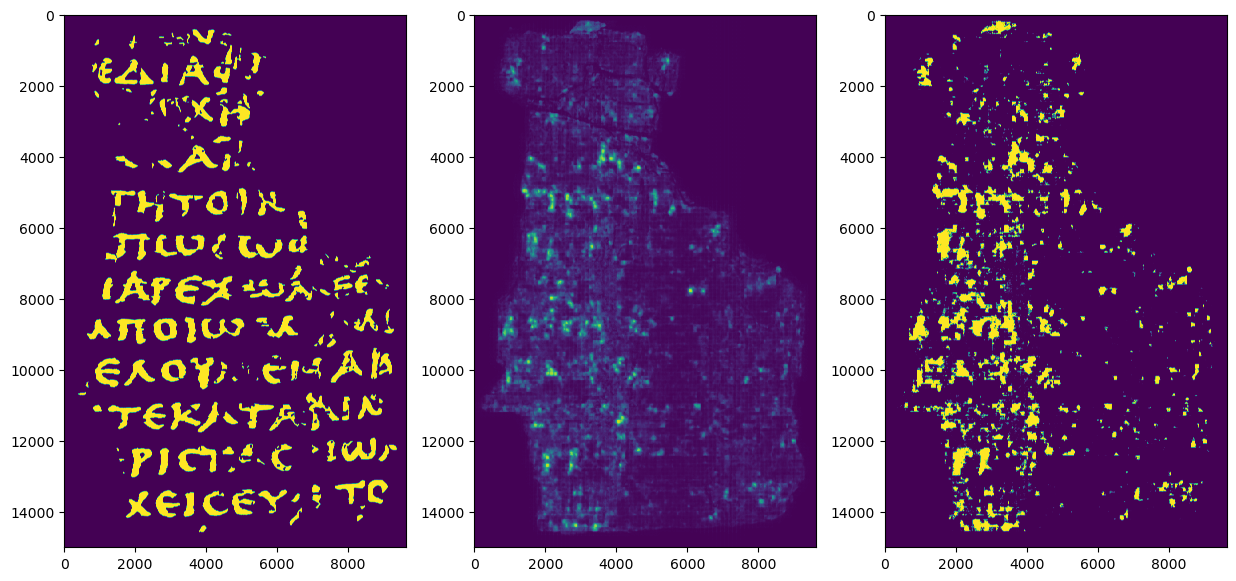

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([9.0960410e+07, 2.8963641e+07, 1.0591111e+07, 5.1141580e+06,
        2.9529210e+06, 1.7851270e+06, 1.0781030e+06, 7.4398000e+05,
        5.5785500e+05, 4.3854000e+05, 3.4062200e+05, 2.6497900e+05,
        2.0114000e+05, 1.6184100e+05, 1.4034500e+05, 1.1349400e+05,
        8.3831000e+04, 5.2482000e+04, 1.1816000e+04, 6.6000000e+02]),
 array([3.92094898e-05, 4.17304887e-02, 8.34217679e-02, 1.25113047e-01,
        1.66804326e-01, 2.08495605e-01, 2.50186885e-01, 2.91878164e-01,
        3.33569443e-01, 3.75260722e-01, 4.16952001e-01, 4.58643281e-01,
        5.00334560e-01, 5.42025839e-01, 5.83717118e-01, 6.25408397e-01,
        6.67099676e-01, 7.08790956e-01, 7.50482235e-01, 7.92173514e-01,
        8.33864793e-01]),
 <BarContainer object of 20 artists>)

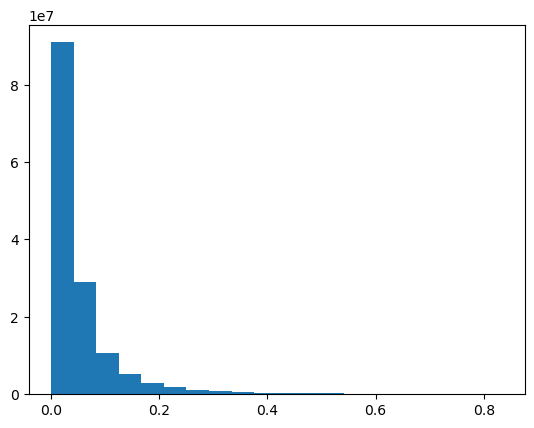

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000